In [1]:
import sys
sys.path.append('/home/juan/Research/Codes/Process Mining')

import os
import numpy as np
import umap
from sklearn.preprocessing import normalize
import pm4py
import hdbscan
from sklearn import metrics
import utils
from PetriNet2Vec import PetriNet2Vec
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
pm4py.util.constants.SHOW_PROGRESS_BAR = False
import warnings
warnings.filterwarnings('ignore')

# Set the seed for reproducibility
random_seed = 42
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

Basic model

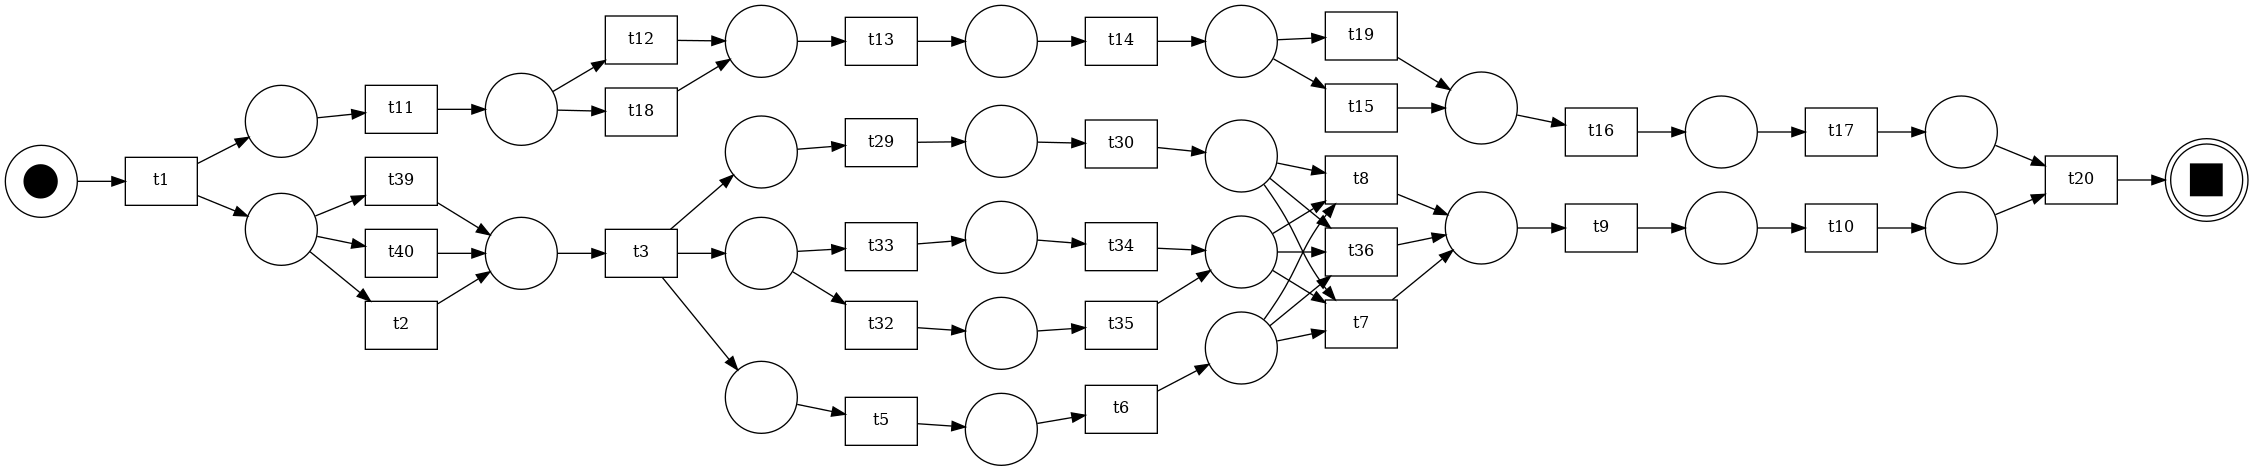

In [2]:
net, im, fm = utils.load_model('../Dataset/Models/pdc2023_000000.pnml')
utils.view(net, im, fm)

Auxiliar functions

In [3]:
def reverse_dict(original_dict):
    reversed_dict = {}
    for key, value in original_dict.items():
        reversed_dict[value] = key
    return reversed_dict

def HDBSCAN_cluster(embeddings_vectors):
    Silhouette = []
    n_clusters = []
    n_noise = []
    for i in range(2,10):    # Hierarchical DBSCAN with cosine similarity
        clusterer = hdbscan.HDBSCAN(min_cluster_size=i) # Hierarchical DBSCAN with cosine similarity
        labels = clusterer.fit_predict(embeddings_vectors)
        # Number of clusters in labels, ignoring noise if present.
        n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
        n_noise.append(list(labels).count(-1))
        if n_clusters[-1] == 0:
            Silhouette.append(0)
        else:
            Silhouette.append(metrics.silhouette_score(embeddings_vectors, labels))
        print(f"Silhouette Coefficient: {Silhouette[-1]:.3f}", 'n_clusters:',n_clusters[-1],'n_noise:', n_noise[-1])

    print("\nBest Silhouette: %f" % (np.max(Silhouette)))
    print("Estimated number of clusters: %d" % n_clusters[np.argmax(Silhouette)])
    print("Estimated number of noise points: %d" % n_noise[np.argmax(Silhouette)])

    # Final clusters with best Silhouette average
    best_i = np.argmax(Silhouette)+2
    clusterer = hdbscan.HDBSCAN(min_cluster_size=best_i)
    labels = clusterer.fit_predict(embeddings_vectors)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    silhouette_avg = metrics.silhouette_score(embeddings_vectors, labels)

    print('best_i:', best_i, 'n_clusters_:', n_clusters_, 'n_noise_:', n_noise_, 'silhouette_avg:', silhouette_avg)

    plt.figure(figsize=(5,4))
    plt.plot(range(2,10), Silhouette)
    plt.ylabel('Silhouette')
    plt.xlabel('minimum cluster size')
    plt.show()

    return labels, n_clusters_

Loading Petri Nets models (dataset)

In [4]:
# PNML Embedding Parameters
embedding_dim = 8 # minimum acceptable number of embedding dimensions
epochs = 1500
neg_sampling = 2

models = sorted(os.listdir('../Dataset/Models/'))
petriNets = []
petriNets_im = []
petriNets_fm = []
for model in models:
    net, im, fm = utils.load_model(os.path.join('../Dataset/Models/', model))
    petriNets.append(net)
    petriNets_im.append(im)
    petriNets_fm.append(fm)

In [5]:
model = PetriNet2Vec(embedding_dim = embedding_dim, seed = random_seed, negative_sampling = neg_sampling, workers=8)
model.fit(petriNets, epochs = epochs)
model.save_model("GT_embeddings")

Tasks histogram

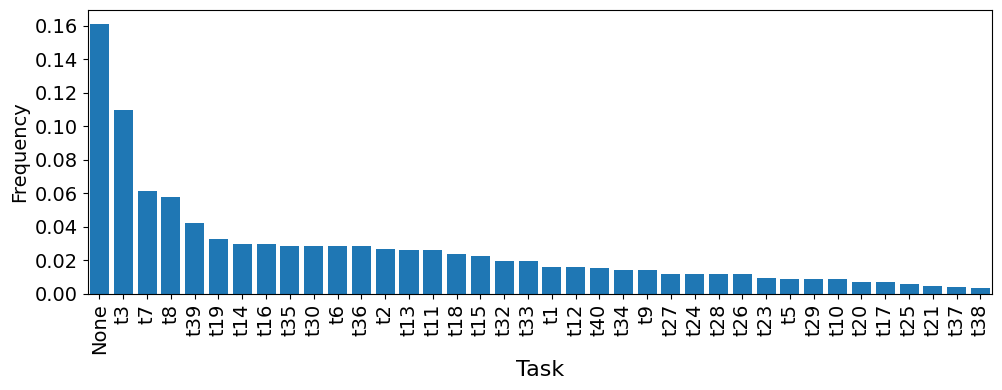

In [6]:
word_count = {key:0 for key, value in model._task_keys.items()}

for doc in model._documents:
    for word in doc.words:
        word_count[word] += 1

# Extract keys and values
x_ticks = list(word_count.keys())
frequencies = list(word_count.values())
frequencies = frequencies/np.sum(frequencies)

# Create the histogram
plt.figure(figsize=(10, 4))
plt.bar(x_ticks, frequencies)
plt.xlabel("Task", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.tight_layout()
plt.xlim([-0.5,37.5])
plt.xticks()
plt.yticks(fontsize=14)
plt.show()

HDBSCAN

Silhouette Coefficient: 0.664 n_clusters: 12 n_noise: 0
Silhouette Coefficient: 0.676 n_clusters: 11 n_noise: 0
Silhouette Coefficient: 0.679 n_clusters: 9 n_noise: 0
Silhouette Coefficient: 0.707 n_clusters: 8 n_noise: 0
Silhouette Coefficient: 0.707 n_clusters: 8 n_noise: 0
Silhouette Coefficient: 0.707 n_clusters: 8 n_noise: 0
Silhouette Coefficient: 0.569 n_clusters: 4 n_noise: 9
Silhouette Coefficient: 0.569 n_clusters: 4 n_noise: 9

Best Silhouette: 0.706509
Estimated number of clusters: 8
Estimated number of noise points: 0
best_i: 5 n_clusters_: 8 n_noise_: 0 silhouette_avg: 0.7065091


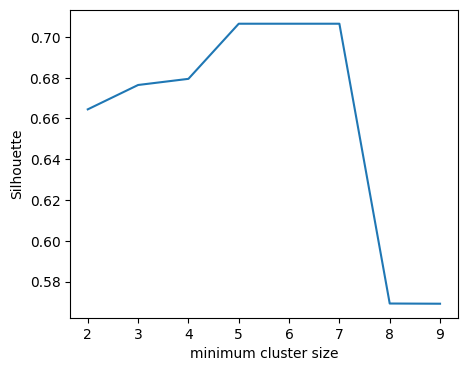

In [7]:
embeddings_vectors = normalize(model.get_net_embeddings().copy())
labels, n_clusters_ = HDBSCAN_cluster(embeddings_vectors)

Plot Silhouette

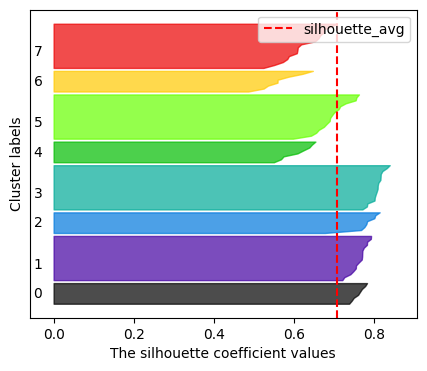

In [8]:
# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(embeddings_vectors, labels)
silhouette_avg = metrics.silhouette_score(embeddings_vectors, labels)

fig, ax1 = plt.subplots(figsize=(5,4))
colors = len(petriNets)*[0]
y_lower = 0
for i in range(n_clusters_):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters_)
    for pos in np.where(labels == i)[0]:
        colors[int(pos)] = color
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.25 * size_cluster_i, str(i))
    # Compute the new y_lower for next plot
    y_lower = y_upper

ax1.set_xlim([-0.06,np.max(ith_cluster_silhouette_values)+0.2])
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster labels")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label='silhouette_avg')
ax1.set_yticks([])  # Clear the yaxis labels / ticks
plt.legend(loc='upper right')
plt.show()


UMAP Net projections

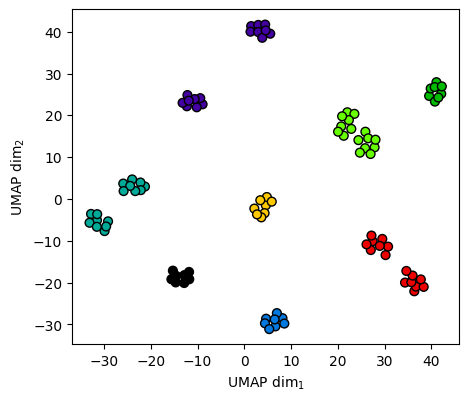

In [9]:
for pos, color in enumerate(colors):
    if color == 0:
        colors[pos] = (1.,1.,1.,1.)

embeddings_vectors = normalize(model.get_net_embeddings().copy())
reducer = umap.UMAP(metric='cosine', spread=10.0, random_state=random_seed)
embedding = reducer.fit_transform(embeddings_vectors)

plt.figure(figsize=(5, 4.35))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='Spectral', s=40, edgecolors='black')
plt.xlabel(r'UMAP dim$_1$')
plt.ylabel(r'UMAP dim$_2$')
plt.show()

View the memebers of some cluster

In [10]:
clusters_members = {}

for cluster in range(n_clusters_):
    print("\nCluster: ", cluster)
    clusters_members[str(cluster)] = []
    for i in np.where(labels==cluster)[0]:
        clusters_members[str(cluster)].append(models[i])
        print(models[i])


Cluster:  0
pdc2023_000100.pnml
pdc2023_000110.pnml
pdc2023_001100.pnml
pdc2023_001110.pnml
pdc2023_100100.pnml
pdc2023_100110.pnml
pdc2023_101100.pnml
pdc2023_101110.pnml

Cluster:  1
pdc2023_010100.pnml
pdc2023_010110.pnml
pdc2023_011100.pnml
pdc2023_011110.pnml
pdc2023_020100.pnml
pdc2023_020110.pnml
pdc2023_021100.pnml
pdc2023_021110.pnml
pdc2023_110100.pnml
pdc2023_110110.pnml
pdc2023_111100.pnml
pdc2023_111110.pnml
pdc2023_120100.pnml
pdc2023_120110.pnml
pdc2023_121100.pnml
pdc2023_121110.pnml

Cluster:  2
pdc2023_000101.pnml
pdc2023_000111.pnml
pdc2023_001101.pnml
pdc2023_001111.pnml
pdc2023_100101.pnml
pdc2023_100111.pnml
pdc2023_101101.pnml
pdc2023_101111.pnml

Cluster:  3
pdc2023_010101.pnml
pdc2023_010111.pnml
pdc2023_011101.pnml
pdc2023_011111.pnml
pdc2023_020101.pnml
pdc2023_020111.pnml
pdc2023_021101.pnml
pdc2023_021111.pnml
pdc2023_110101.pnml
pdc2023_110111.pnml
pdc2023_111101.pnml
pdc2023_111111.pnml
pdc2023_120101.pnml
pdc2023_120111.pnml
pdc2023_121101.pnml
pdc2023_

pdc2023_000000.pnml


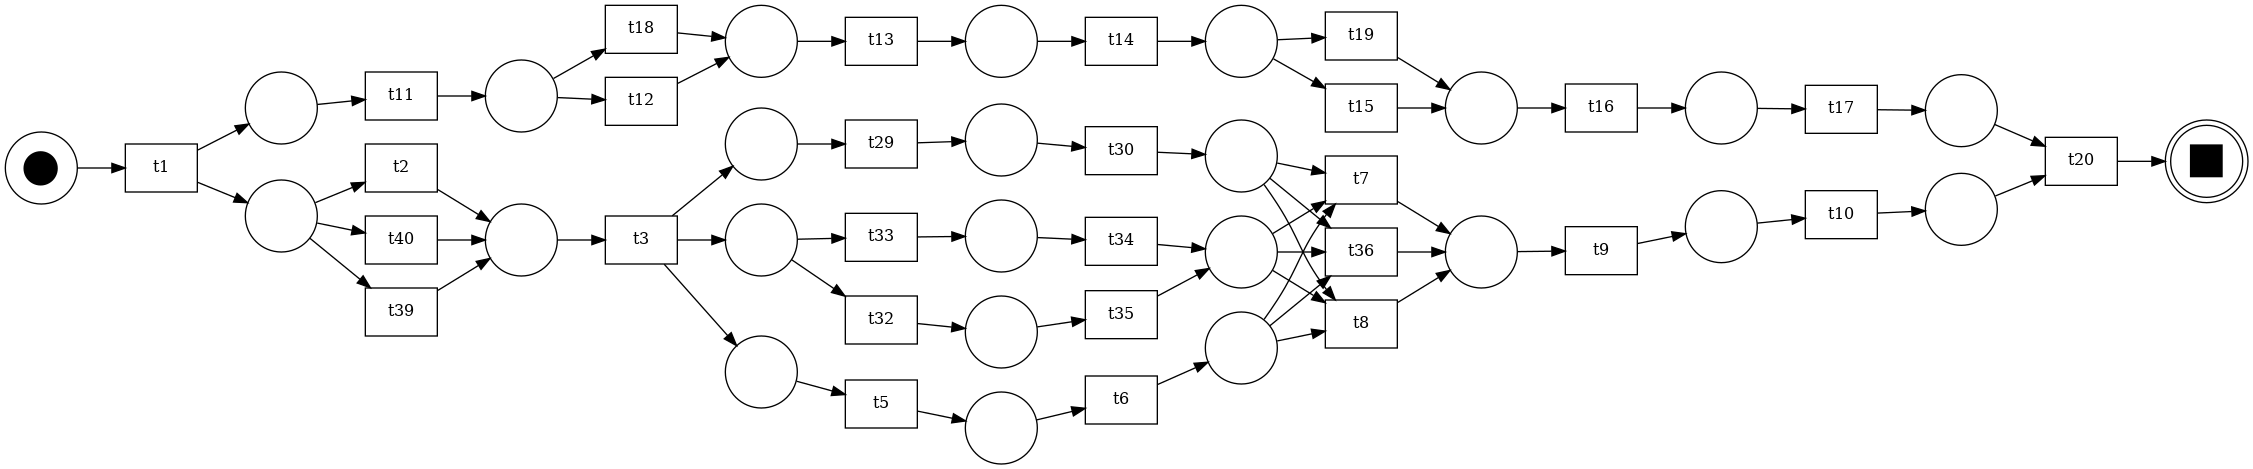

pdc2023_000010.pnml


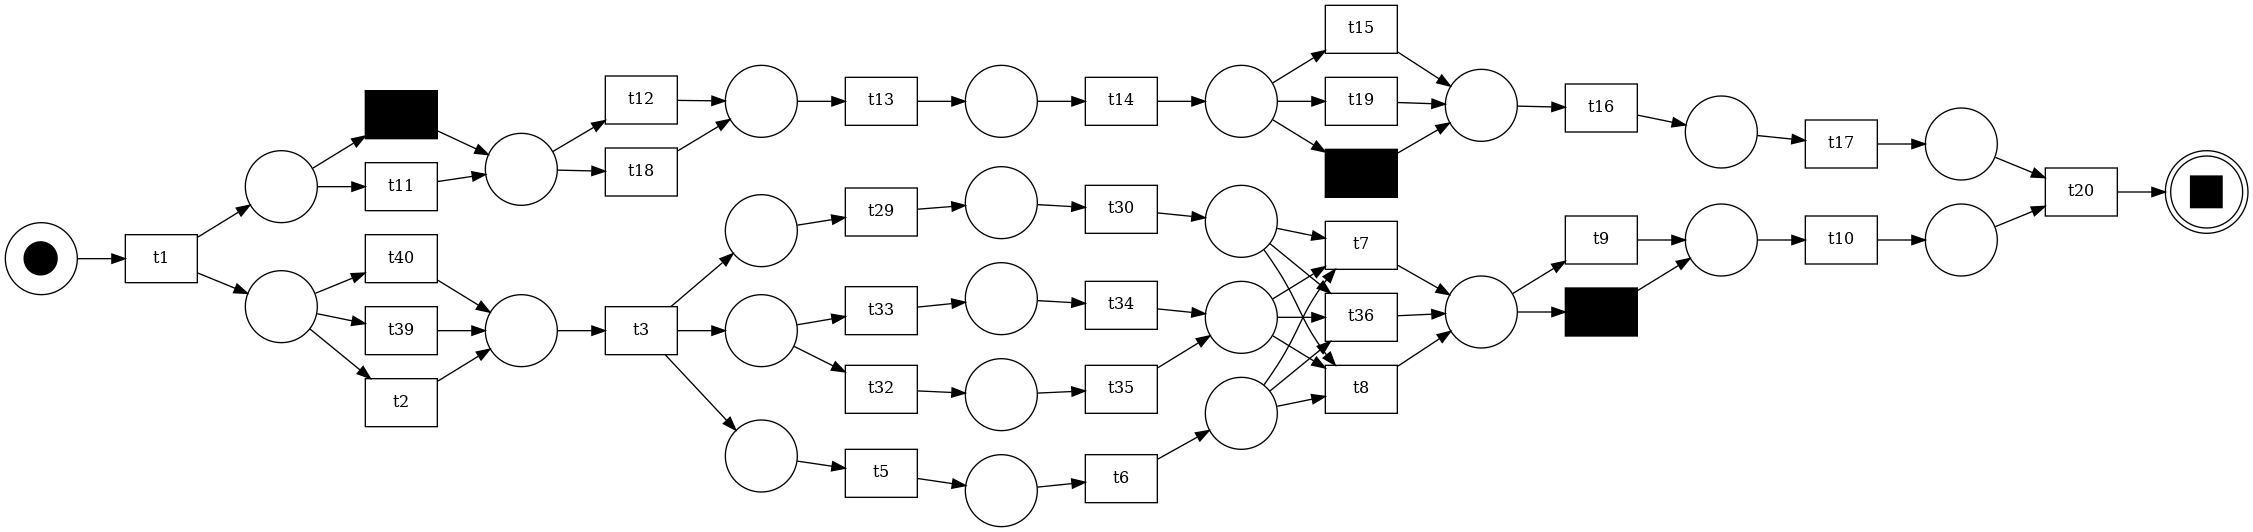

pdc2023_001000.pnml


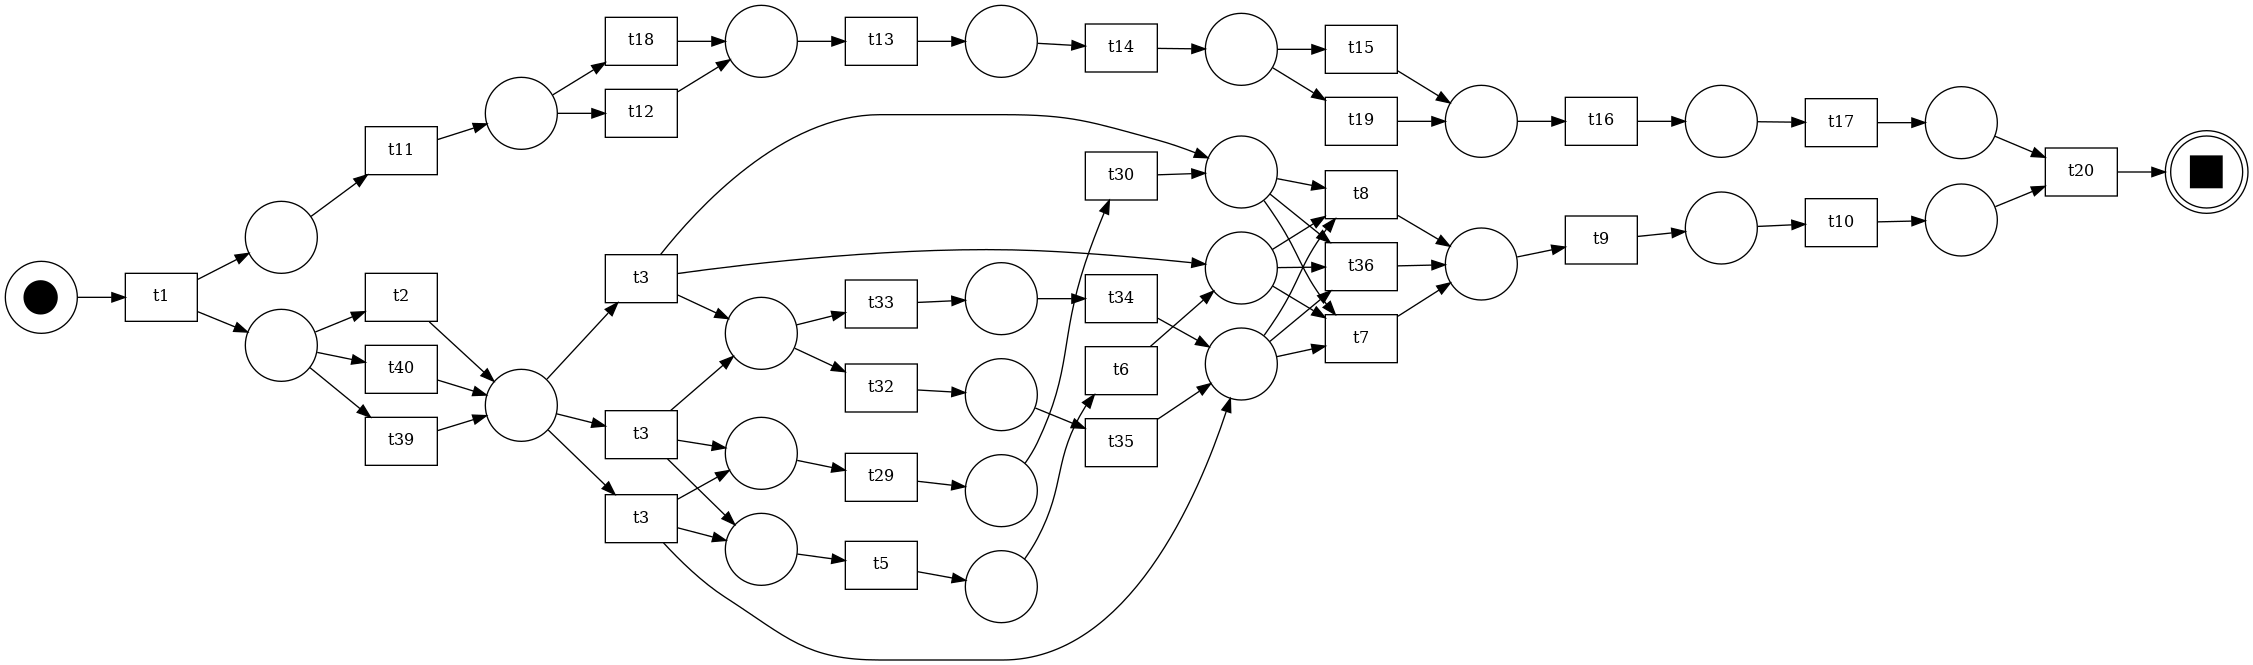

pdc2023_001010.pnml


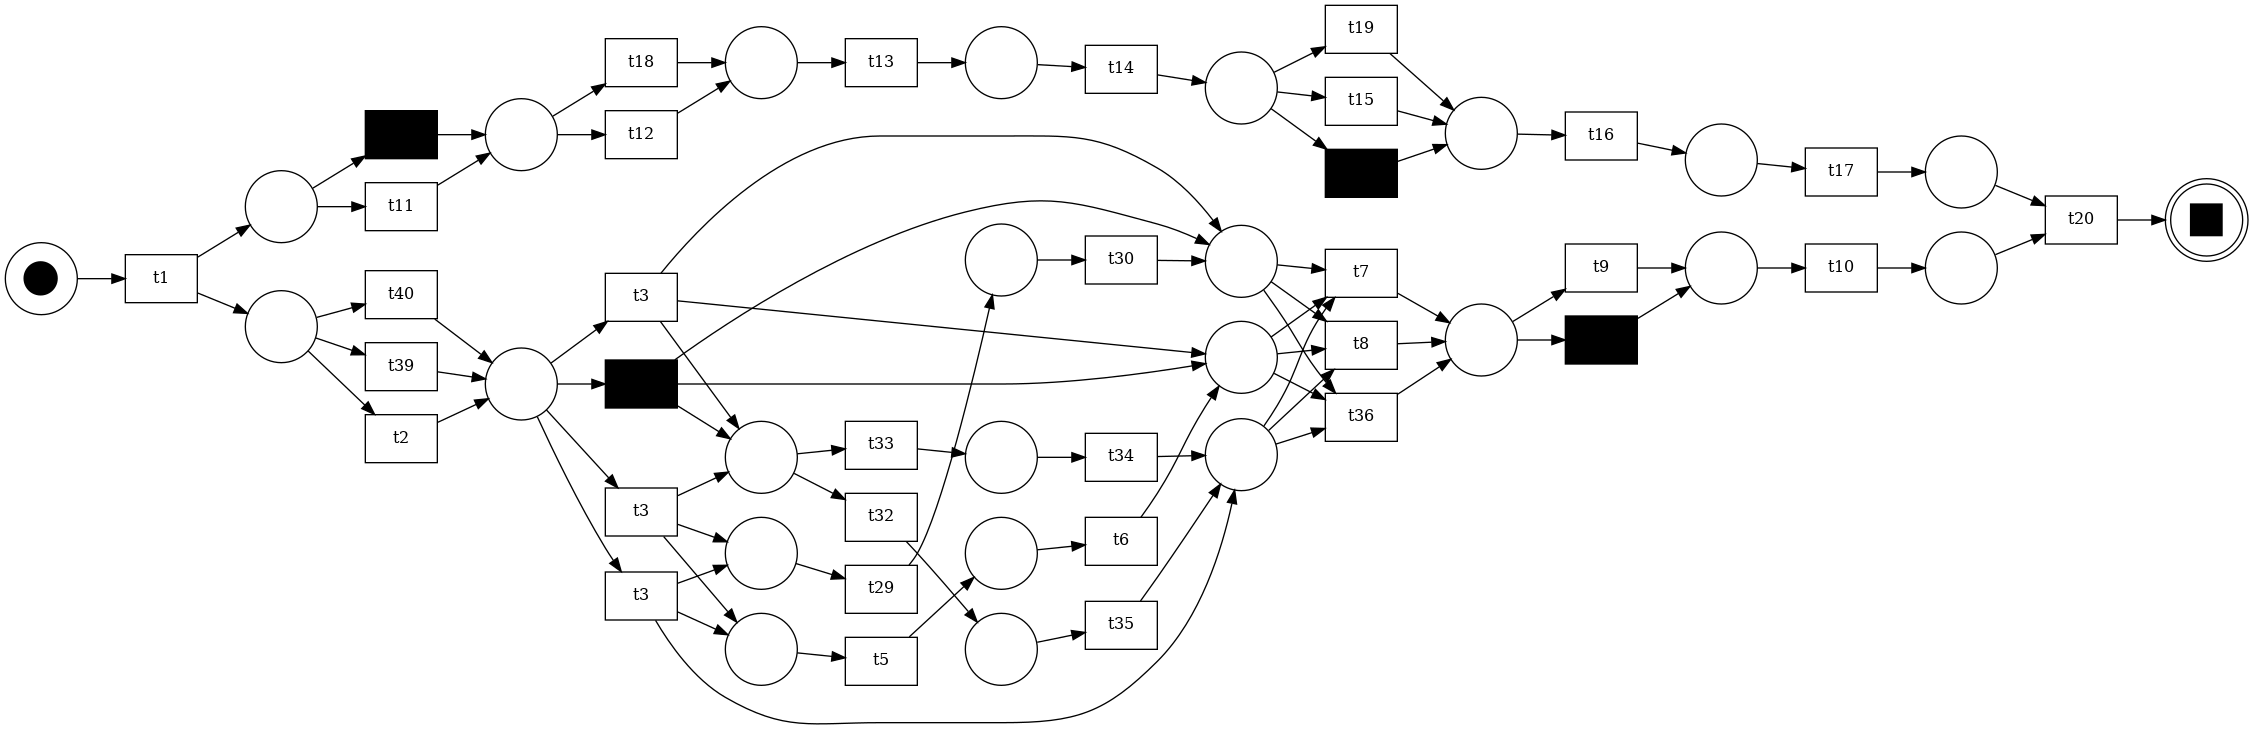

In [27]:
# showing the fisrt four cluster members
for i, member in enumerate(clusters_members['4']):
    if i < 4:
        print(member)
        net, im, fm = utils.load_model(os.path.join('../Dataset/Models/', member))
        utils.view(net, im, fm)

Solving similar query model

pdc2023_010100.pnml


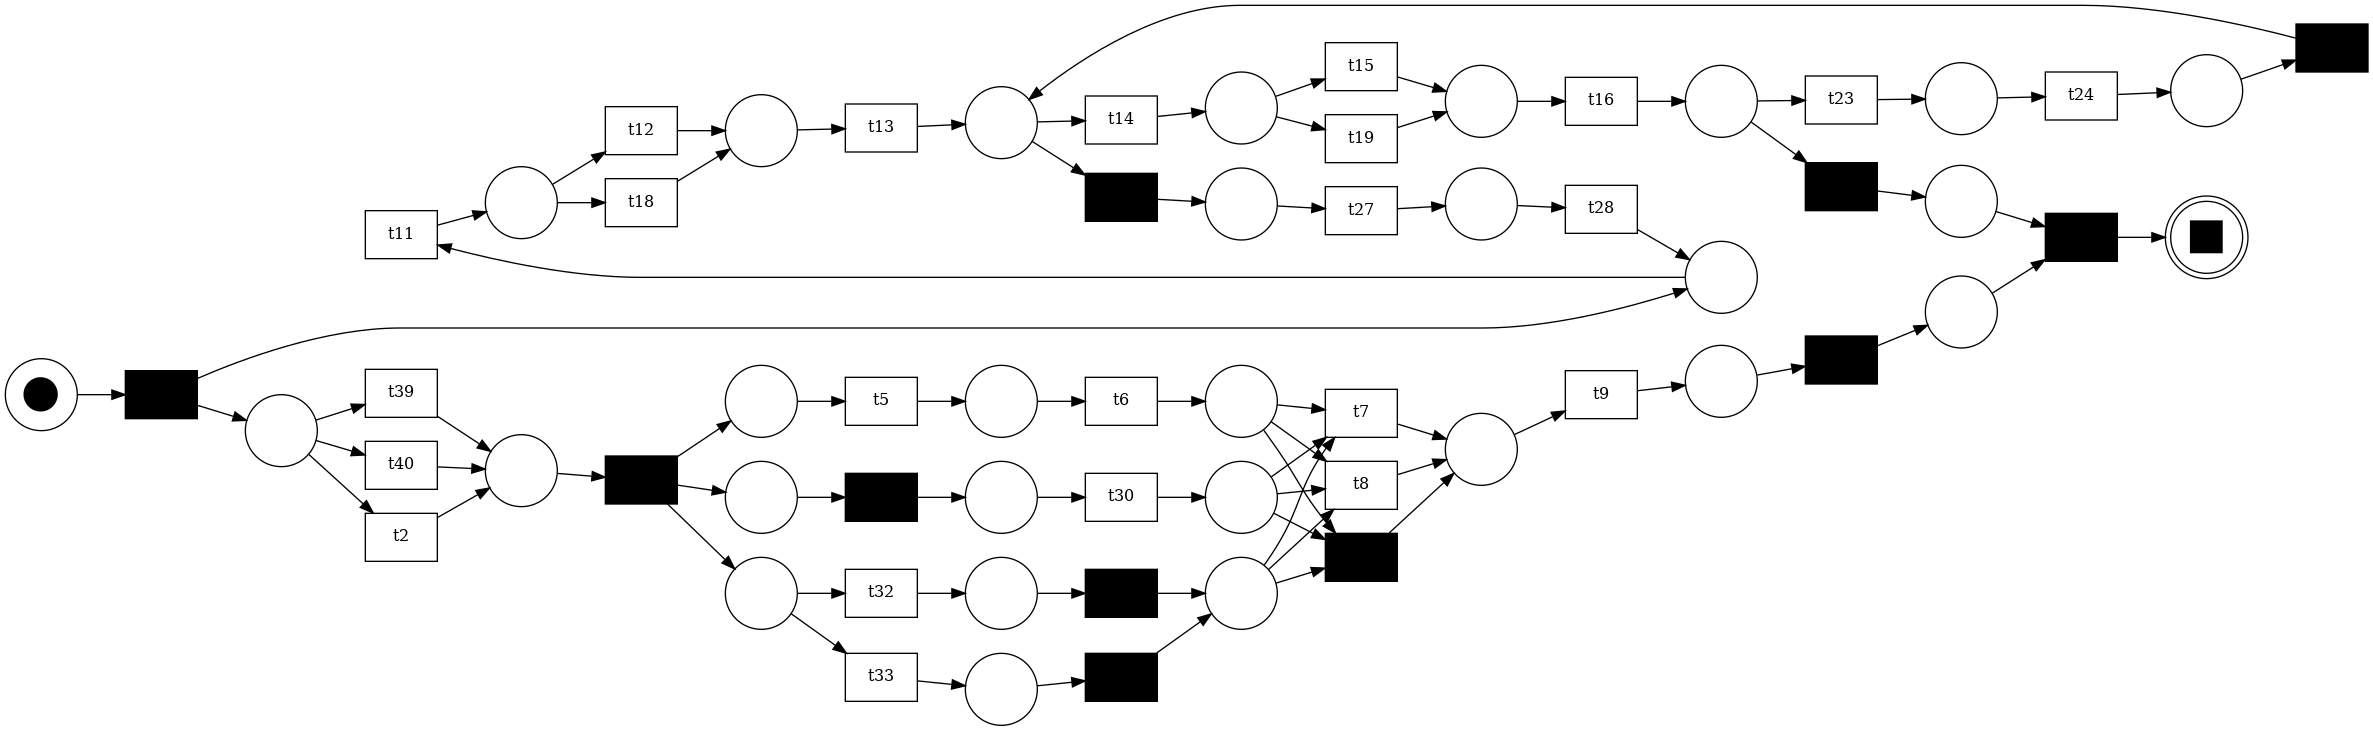

36 pdc2023_020100.pnml


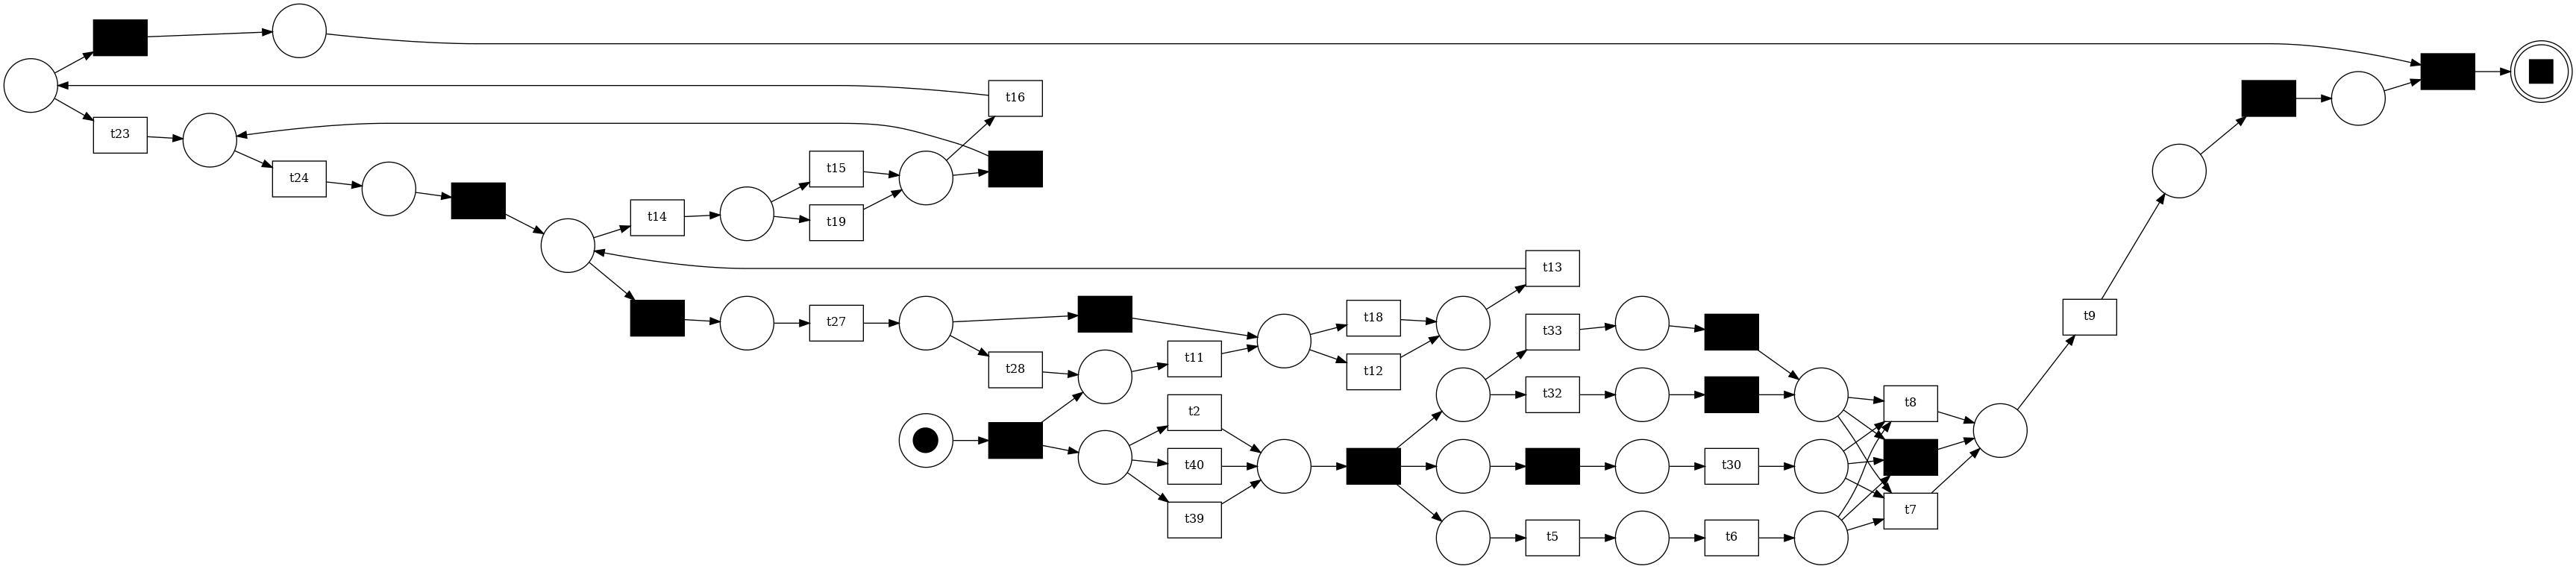

In [22]:
j = '20'
net_id = model._net_keys[j]

print(models[net_id])
utils.view(petriNets[net_id], petriNets_im[net_id], petriNets_fm[net_id])

models_embeddings = normalize(model.get_net_embeddings().copy())
sim_matrix = [model.similarity(embedding, models_embeddings[net_id]) for embedding in models_embeddings]
nearest_neighbor = np.argsort(sim_matrix)[::-1][2]

print(nearest_neighbor, models[nearest_neighbor])
utils.view(petriNets[nearest_neighbor], petriNets_im[nearest_neighbor], petriNets_fm[nearest_neighbor])

Cluster of task embeddings - HDBSCAN

Silhouette Coefficient: 0.235 n_clusters: 4 n_noise: 12
Silhouette Coefficient: 0.174 n_clusters: 4 n_noise: 16
Silhouette Coefficient: 0.181 n_clusters: 3 n_noise: 19
Silhouette Coefficient: 0.000 n_clusters: 0 n_noise: 38
Silhouette Coefficient: 0.000 n_clusters: 0 n_noise: 38
Silhouette Coefficient: 0.000 n_clusters: 0 n_noise: 38
Silhouette Coefficient: 0.000 n_clusters: 0 n_noise: 38
Silhouette Coefficient: 0.000 n_clusters: 0 n_noise: 38

Best Silhouette: 0.234529
Estimated number of clusters: 4
Estimated number of noise points: 12
best_i: 2 n_clusters_: 4 n_noise_: 12 silhouette_avg: 0.23452874


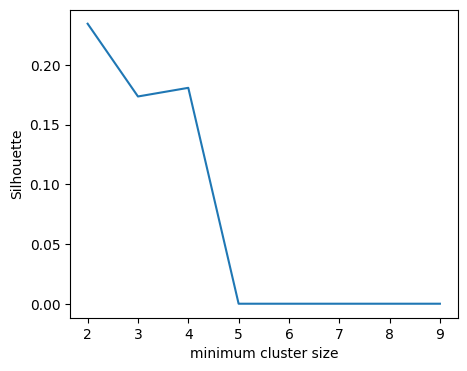

In [13]:
embeddings_vectors = normalize(model.get_task_embeddings().copy())
labels, n_clusters_ = HDBSCAN_cluster(embeddings_vectors)

Silhouette Plot

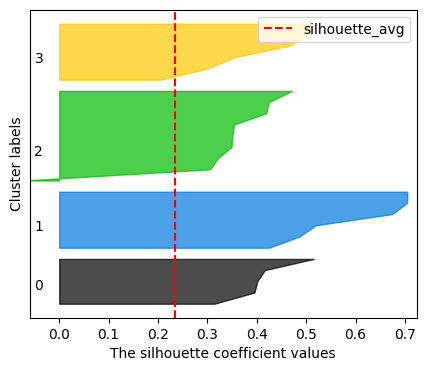

In [14]:
# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(embeddings_vectors, labels)
silhouette_avg = metrics.silhouette_score(embeddings_vectors, labels)

fig, ax1 = plt.subplots(figsize=(5,4))
colors = len(sample_silhouette_values)*[0]
y_lower = 0
for i in range(n_clusters_):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters_)
    for pos in np.where(labels == i)[0]:
        colors[int(pos)] = color
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.25 * size_cluster_i, str(i))
    # Compute the new y_lower for next plot
    y_lower = y_upper

ax1.set_xlim([-0.06,np.max(ith_cluster_silhouette_values)+0.2])
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster labels")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label='silhouette_avg')
ax1.set_yticks([])  # Clear the yaxis labels / ticks
plt.legend(loc='upper right')
plt.show()

UMAP task embeddings

In [15]:
embeddings_vectors = normalize(model.get_task_embeddings().copy())
reducer = umap.UMAP(metric='cosine', spread=5, random_state=random_seed)
embedding = reducer.fit_transform(embeddings_vectors)

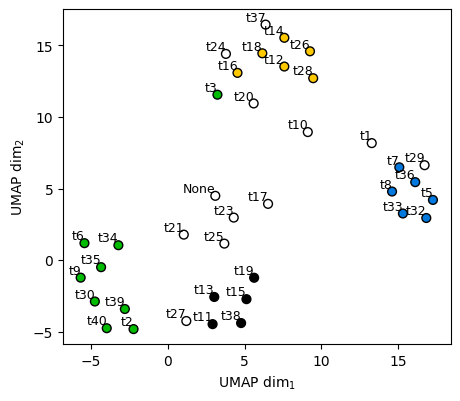

In [16]:
for pos, color in enumerate(colors):
    if color == 0:
        colors[pos] = (1.,1.,1.,1.)

plt.figure(figsize=(5, 4.35))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='Spectral', s=40, edgecolors='black')
for key, value in model._task_keys.items():
    plt.text(embedding[value,0]+0.025, embedding[value,1]+0.025, key, fontsize=9, ha='right', va='bottom')

#plt.colorbar()
plt.xlabel(r'UMAP dim$_1$')
plt.ylabel(r'UMAP dim$_2$')
plt.show()

Query an specific task

In [18]:
query = 't40'
task_embeddings = normalize(model.get_task_embeddings().copy())
task1 = model.get_task_embeddings(query).copy()
sim_matrix = [model.similarity(task1, embedding) for embedding in task_embeddings]
nearest_neighbor = np.argsort(sim_matrix)[::-1][2]
keys_task = reverse_dict(model._task_keys)
print('query:', query, 'result:', keys_task[int(nearest_neighbor)])

query: t40 result: t2
